In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn/pppc')
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn')
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tifffile


import pppc
from pppc.configs import InferenceConfigDict
from pppc.core import PtychoNNProbePositionCorrector, ProbePositionCorrectorChain
from pppc.ptychonn.model import PtychoNNModel
from pppc.io import DataFileHandle, NPZFileHandle, VirtualDataFileHandle
from pppc.position_list import ProbePositionList
from pppc.reconstructor import VirtualReconstructor
from pppc.util import class_timeit

[2023-12-11 14:40:39,813] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2023-12-11 14:40:39,818] NumExpr defaulting to 8 threads.


In [3]:
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 14
plt.viridis()

<Figure size 640x480 with 0 Axes>

In [4]:
scan_idx = 253
save_figs = True
output_dir = os.path.join('outputs', 'test{}'.format(scan_idx))
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

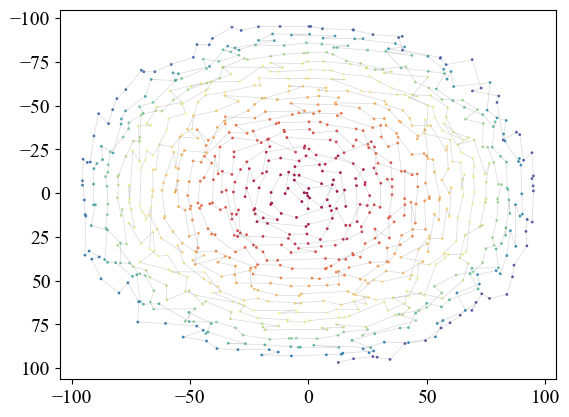

In [5]:
psize_nm = np.load('data/scan221_raw.npz')['pixelsize'] * 1e9
probe_pos_list = ProbePositionList(file_path='data/pos{}.csv'.format(scan_idx),
                                   unit='m', psize_nm=psize_nm, convert_to_pixel=True, first_is_x=False)
fig, ax, scat = probe_pos_list.plot(show=False, return_obj=True)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_true.pdf'.format(scan_idx))
else:
    plt.show()

In [6]:
try:
    recons = tifffile.imread('outputs/pred_test{}_model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/pred_phase.tiff'.format(scan_idx))
except:
    recons = tifffile.imread('outputs/pred_scan{}_model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/pred_phase.tiff'.format(scan_idx))
#recons = tifffile.imread('data/scan{}_phase.tiff'.format(scan_idx))
config_dict = InferenceConfigDict()
config_dict['model_path'] = '../../trained_models/model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth'
config_dict['model'] = (PtychoNNModel, {'n_levels': 4})
# config_dict['dp_data_file_handle'] = NPZFileHandle('data/test{}.npz'.format(scan_idx))
config_dict['dp_data_file_handle'] = VirtualDataFileHandle('', dp_shape=recons.shape[1:], num_dps=recons.shape[0])
# config_dict['dp_data_file_handle'].transform_data((128, 128), discard_len=(64, 64))
config_dict['ptycho_reconstructor'] = VirtualReconstructor(InferenceConfigDict())
config_dict['ptycho_reconstructor'].set_object_image_array(recons)
config_dict['random_seed'] = 196 
config_dict['debug'] = False
config_dict['probe_position_list'] = None
config_dict['central_crop'] = None

Serial correction

In [7]:
config_dict.load_from_json(os.path.join('config_jsons', 'config_{}.json'.format(scan_idx)))
config_dict

batch_size: 1
model_path: ../../trained_models/model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth
model: (<class 'pppc.ptychonn.model.PtychoNNModel'>, {'n_levels': 4})
prediction_output_path: None
cpu_only: False
registration_method: error_map
sift_outlier_removal_method: trial_error
dp_data_file_path: None
dp_data_file_handle: <pppc.io.VirtualDataFileHandle object at 0x7f85b434f850>
probe_position_list: None
probe_position_data_path: None
probe_position_data_unit: None
pixel_size_nm: None
central_crop: None
method: collective
max_shift: 40
num_neighbors_collective: 12
offset_estimator_order: 1
offset_estimator_beta: 0.5
smooth_constraint_weight: 0.01
random_seed: 196
debug: False
ptycho_reconstructor: <pppc.reconstructor.VirtualReconstructor object at 0x7f85b3cbfc10>
method_multiiter: ['serial', 'collective', 'collective']
registration_method_multiiter: ['sift', 'sift', 'sift']
smooth_constraint_weight_multiiter: [0

In [8]:
corrector_chain = ProbePositionCorrectorChain(config_dict)
corrector_chain.build()

[2023-12-11 14:40:42,548] Now running iteration 0.
[2023-12-11 14:40:42,549] Random seed is set to 196.


batch_size: 1
model_path: ../../trained_models/model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth
model: (<class 'pppc.ptychonn.model.PtychoNNModel'>, {'n_levels': 4})
prediction_output_path: None
cpu_only: False
registration_method: sift
sift_outlier_removal_method: trial_error
dp_data_file_path: None
dp_data_file_handle: <pppc.io.VirtualDataFileHandle object at 0x7f85b434f850>
probe_position_list: None
probe_position_data_path: None
probe_position_data_unit: None
pixel_size_nm: None
central_crop: None
method: serial
max_shift: 40
num_neighbors_collective: 12
offset_estimator_order: 1
offset_estimator_beta: 0.5
smooth_constraint_weight: 0
random_seed: 196
debug: False
ptycho_reconstructor: <pppc.reconstructor.VirtualReconstructor object at 0x7f85b3cbfc10>
method_multiiter: ['serial', 'collective', 'collective']
registration_method_multiiter: ['sift', 'sift', 'sift']
smooth_constraint_weight_multiiter: [0, 0.01, 0.00

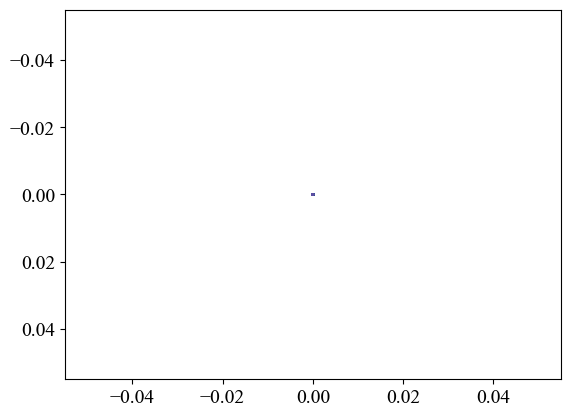

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 960/960 [01:24<00:00, 11.39it/s]


In [9]:
corrector_chain.run_correction_iteration(0)

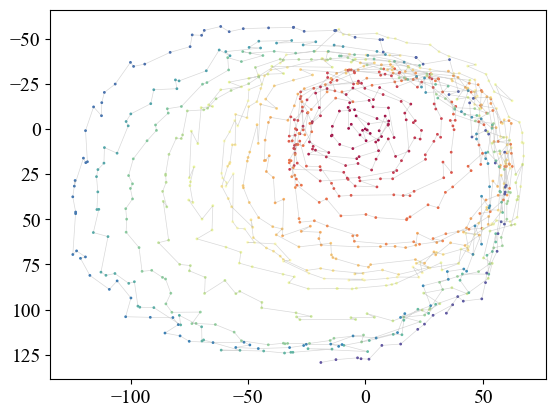

In [10]:
corrector_s = corrector_chain.corrector_list[-1]
fig, ax, scat = corrector_s.new_probe_positions.plot(return_obj=True, show=False)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_serial.pdf'.format(scan_idx))
else:
    plt.show()

[2023-12-11 14:42:08,611] Now running iteration 1.
[2023-12-11 14:42:08,612] Using result from the last iteration to initialize probe position array...
[2023-12-11 14:42:08,613] Random seed is set to 196.


batch_size: 1
model_path: ../../trained_models/model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth
model: (<class 'pppc.ptychonn.model.PtychoNNModel'>, {'n_levels': 4})
prediction_output_path: None
cpu_only: False
registration_method: sift
sift_outlier_removal_method: trial_error
dp_data_file_path: None
dp_data_file_handle: <pppc.io.VirtualDataFileHandle object at 0x7f85b434f850>
probe_position_list: <pppc.position_list.ProbePositionList object at 0x7f85b3b5a390>
probe_position_data_path: None
probe_position_data_unit: None
pixel_size_nm: None
central_crop: None
method: collective
max_shift: 40
num_neighbors_collective: 12
offset_estimator_order: 1
offset_estimator_beta: 0.5
smooth_constraint_weight: 0.01
random_seed: 196
debug: False
ptycho_reconstructor: <pppc.reconstructor.VirtualReconstructor object at 0x7f85b3cbfc10>
method_multiiter: ['serial', 'collective', 'collective']
registration_method_multiiter: ['sift', 

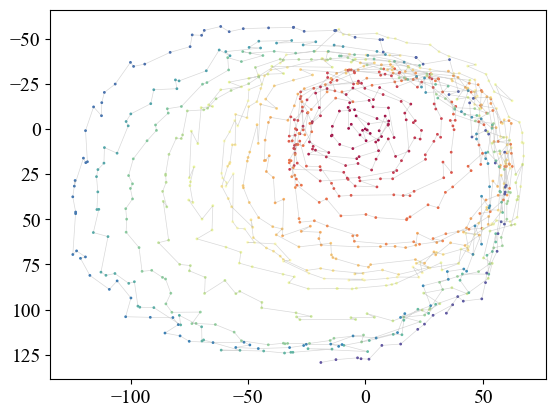

 11%|████████████████████████▋                                                                                                                                                                                                                | 102/961 [01:06<11:37,  1.23it/s][2023-12-11 14:43:16,098] Large error after applying offset (1.0863641347989195).
[2023-12-11 14:43:16,480] Large error after applying offset (0.7471164458835516).
 11%|████████████████████████▉                                                                                                                                                                                                                | 103/961 [01:07<12:07,  1.18it/s][2023-12-11 14:43:17,013] Large error after applying offset (0.7698684823474801).
[2023-12-11 14:43:17,335] Large error after applying offset (1.3032893163688917).
 11%|█████████████████████████▏                                                                                                 

In [11]:
# corrector_chain.config_dict['sift_outlier_removal_method'] = 'trial_error'
corrector_chain.run_correction_iteration(1)

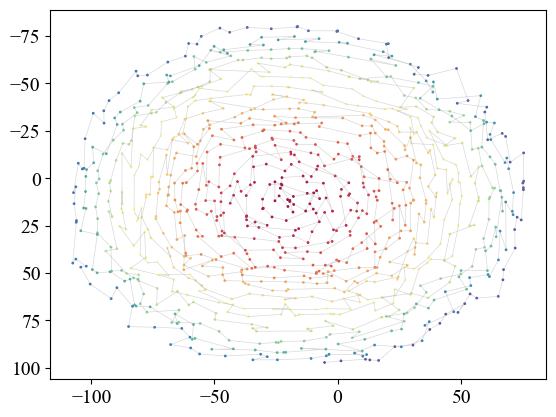

In [12]:
corrector_c1 = corrector_chain.corrector_list[1]
fig, ax, scat = corrector_c1.new_probe_positions.plot(return_obj=True, show=False)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_collective_iter_1_nn_12_sw_1e-2.pdf'.format(scan_idx), format='pdf')
else:
    plt.show()

[2023-12-11 14:52:03,284] Now running iteration 2.
[2023-12-11 14:52:03,286] Using result from the last iteration to initialize probe position array...
[2023-12-11 14:52:03,287] Random seed is set to 196.


batch_size: 1
model_path: ../../trained_models/model_36SpiralDatasets_model_PtychoNNModel_nLevels_4_batchSizePerProcess_32_learningRatePerProcess_0.0001/best_model.pth
model: (<class 'pppc.ptychonn.model.PtychoNNModel'>, {'n_levels': 4})
prediction_output_path: None
cpu_only: False
registration_method: sift
sift_outlier_removal_method: trial_error
dp_data_file_path: None
dp_data_file_handle: <pppc.io.VirtualDataFileHandle object at 0x7f85b434f850>
probe_position_list: <pppc.position_list.ProbePositionList object at 0x7f85b02f8dd0>
probe_position_data_path: None
probe_position_data_unit: None
pixel_size_nm: None
central_crop: None
method: collective
max_shift: 40
num_neighbors_collective: 12
offset_estimator_order: 1
offset_estimator_beta: 0.5
smooth_constraint_weight: 0.001
random_seed: 196
debug: False
ptycho_reconstructor: <pppc.reconstructor.VirtualReconstructor object at 0x7f85b3cbfc10>
method_multiiter: ['serial', 'collective', 'collective']
registration_method_multiiter: ['sift',

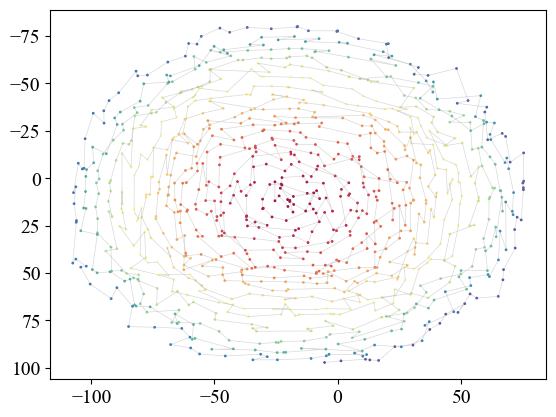

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 961/961 [09:19<00:00,  1.72it/s]


In [13]:
corrector_chain.run_correction_iteration(2)

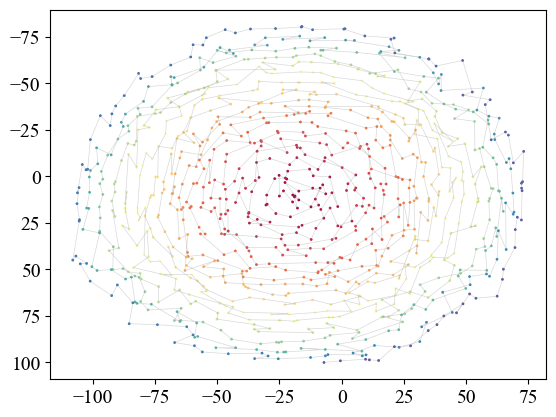

In [14]:
corrector_c2 = corrector_chain.corrector_list[2]
fig, ax, scat = corrector_c2.new_probe_positions.plot(return_obj=True, show=False)
if save_figs:
    fig.savefig('outputs/test{}/path_plot_collective_iter_2_nn_12_sw_1e-3_1e-2.pdf'.format(scan_idx), format='pdf')
else:
    plt.show()

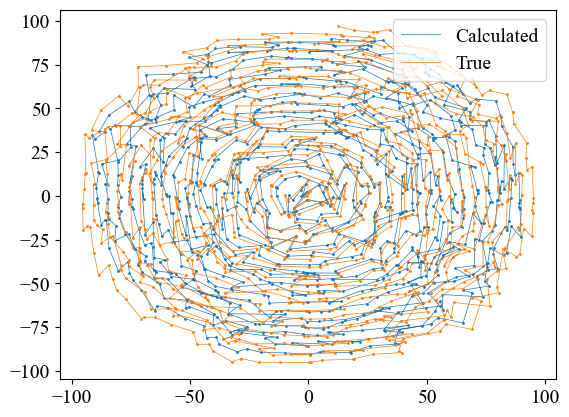

In [15]:
probe_pos_list_calc = corrector_c2.new_probe_positions.array
probe_pos_list_true = np.genfromtxt('data/pos{}.csv'.format(scan_idx), delimiter=',').astype('float32') / (psize_nm * 1e-9)
probe_pos_list_calc -= np.mean(probe_pos_list_calc, axis=0)
probe_pos_list_true -= np.mean(probe_pos_list_true, axis=0)
# probe_pos_list_raw *= 1.05
plt.scatter(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], s=1)
plt.scatter(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], s=1)
plt.plot(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], linewidth=0.5, label='Calculated')
plt.plot(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], linewidth=0.5, label='True')
plt.legend()
if save_figs:
    plt.savefig('outputs/test{}/comparison_path_plot_collective_iter_2_nn_12_sw_1e-3_1e-2.pdf'.format(scan_idx))
else:
    plt.show()

In [16]:
if save_figs:
    corrector_c2.new_probe_positions.to_csv(os.path.join(output_dir, 'calc_pos_{}_collective_niters_2_beta_0p5_nn_12_sw_1e-2_1e-3.csv'.format(scan_idx)), psize_nm=psize_nm)